In [1]:
import numpy as np
import pandas as pd
import os
import glob
import python_speech_features as mfcc
from scipy.io.wavfile import read
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import re
%matplotlib inline

In [2]:
#All global variables should be here
pwd = os.getcwd() #this is the current working directory
genderDict = {'M':0,'F':1}
speakerDict = {}

In [3]:
#pushing the indexes to 0 to redue the size of one hot vector
for i in range(1,143):
    speakerDict[i] = i-1 

In [4]:
class dataLoader(object):
    '''data loader class to load the data from the dictionary for both problems'''
    
    def __init__(self,problem,scaling=0):
        '''initializing directories based on problem and specifying whether scaling is required or not'''
        self.problem = problem 
        if self.problem==0:
            #if problem is of gender recognition
            self.DIR = "\\Gender_Recognition\\"
        elif self.problem==1:
            #if problem is of speaker recognition
            self.DIR = "\\Speaker_Recognition\\"
        else:
            #if problem is none raise error
            print("Values can only be 0 or 1")
            raise NotImplementedError(0)
        #setting the scaling variable
        self.scaling=scaling
        
    def returnData(self):
        '''function to return the processed data and scale it if scaling is set'''
        ###Naming conventions for train/test/val data XTrain/XTest/XVal
        self.XTrain,self.YTrain = self.dataLoader("Train",self.problem)
        self.XTest,self.YTest = self.dataLoader("Test",self.problem)
        self.XVal,self.YVal = self.dataLoader("Valid",self.problem)
        self.YTrain = self.YTrain.reshape(self.YTrain.shape[0],1)
        self.YTest = self.YTest.reshape(self.YTest.shape[0],1)
        self.YVal = self.YVal.reshape(self.YVal.shape[0],1)
        #Doing feature scaling if self.scaling is true 
        #Ignoring the bias term as that will just 0 it
        mean = np.mean(self.XTrain[:,1:],axis=0)
        std = np.std(self.XTrain[:,1:],axis=0)

        #if scaling needs to be done
        if self.scaling:
            self.XTrain[:,1:] = (self.XTrain[:,1:]-mean)/std
            self.XTest[:,1:] = (self.XTest[:,1:]-mean)/std
            self.XVal[:,1:] = (self.XTest[:,1:]-mean)/std
        
        #converting to one hot enocding vectors
        self.YTrainOne = self.oneHotEncoderProcessing(self.YTrain,self.problem)
        self.YTestOne = self.oneHotEncoderProcessing(self.YTest,self.problem)
        self.YValOne = self.oneHotEncoderProcessing(self.YVal,self.problem)
        return (self.XTrain,self.YTrain,self.XTest,self.YTest,self.XVal,self.YVal)

    def oneHotEncoderProcessing(self,data,problem):
        '''function to convert labels to one hot encoding array'''
        oneHot = []
        classes = np.unique(data)
        for example in data:
            ex = np.zeros((len(classes)))
            ex[example[0]] = 1 
            oneHot.append(ex)
        return np.array(oneHot)
    
    def returnHotEncodings(self):
        '''function to return one hot encodings of the data'''
        return (self.YTrainOne,self.YTestOne,self.YValOne)

    def get_MFCC(self,audio, sr):
        '''blackbox function provided by the TA'''
        features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
        return np.mean(features, axis=0)

    def dataLoader(self,dirName,problem):
        '''function to load data depending on the problem'''
        #if problem is gender recognition
        if problem==0:
            labels = []
            data = []
            names = []
            for name in glob.glob(pwd+self.DIR+str(dirName)+"\\*"):
               #label is M or F which is last word of file
                label = name[-1]
                #reading the wave files in the directory
                for subnames in glob.glob(name+"\\*"):
                    #convertin the wave files to features and appending
                    sr, audio = read(subnames)
                    features =np.append(1 ,self.get_MFCC(audio, sr)) #adding the bias term
                    data.append(features)
                    #converting labels to 0/1 depending upon genderDict
                    labels.append(genderDict[label])
                    names.append(subnames)
        #if problem is speaker recognition
        if problem==1:
            labels = []
            data = []
            names = []
            for name in glob.glob(pwd+self.DIR+str(dirName)+"\\*"):
                #using regex capture groups to read the speaker identity
                pattern = re.search("([0-9]{3})",name)
                label = int(pattern.group(1))
                #reading the wave files in the directory
                for subnames in glob.glob(name+"\\*"):
                    #converting to features and appending
                    sr, audio = read(subnames)
                    features =np.append(1 ,self.get_MFCC(audio, sr)) #adding the bias term
                    data.append(features)
                    #converting to labels depending upon the speaker dict
                    labels.append(speakerDict[label])
                    names.append(subnames)
        #returning the data
        return (np.array(data),np.array(labels))

In [5]:
#Data loading for gender recognition problem
loaderp1 = dataLoader(0)
XTrainp1,YTrainp1,XTestp1,YTestp1,XValp1,YValp1 = loaderp1.returnData()
YTrainOnep1,YTestOnep1,YValOnep1 = loaderp1.returnHotEncodings()

In [6]:
#Data loading for the speaker recognition problem
loaderp2 = dataLoader(1,0)
XTrainp2,YTrainp2,XTestp2,YTestp2,XValp2,YValp2 = loaderp2.returnData()
YTrainOnep2,YTestOnep2,YValOnep2 = loaderp2.returnHotEncodings()

In [7]:
class LogisticRegression:
    '''class to perform logistic regression'''
    def __init__(self,XTrain,YTrain,epochs=5000,lr=10,problem=0):
        '''function to initialize epochs,proble,lr and class weights'''
        self.epochs = epochs
        self.problem = problem
        self.lr = lr
        self.epochs = epochs
        classes = np.unique(YTrain)
        self.W = np.zeros(shape=(14,len(classes)))
    def linear(self,X):    
        '''function calculating the dot product'''
        z = np.dot(X,self.W)
        return z
    def softmax(self,z):
        '''function applying softmax'''
        t = np.exp(z)
        division = np.sum(t,axis=1)
        division = division.reshape(division.shape[0],1)
        return t/(division)
    def cross_entropy(self,ypred,ytarget):
        '''function to calculate loss'''
        #epsilon added to avoid NANs
        epsilon = 0.1
        return -np.sum(np.sum(np.log(ypred+epsilon)*ytarget))
    
    def oneHotEncoder(self,data,problem):
        '''function to convert labels to one hot encoding'''
        oneHot = []
        #classes = np.unique(data)
        for example in data:
            if self.problem==0:
                ex = np.zeros((2))
            if self.problem==1:
                ex = np.zeros((142))
            ex[example] = 1 
            oneHot.append(ex)
       
        return np.array(oneHot)
    
    def gradient_descent(self,X,Y,XVal,YVal):
        '''function to perform gradient descent'''
        #getting number of training examples
        m = X.shape[0]
        #getting labels of classes
        ytrue = np.argmax(Y,axis=1)
        #getting number of unique classes in the data and initializing weights
        self.classes = np.unique(ytrue)
#         print("Classes=",self.classes)
        self.W = np.zeros(shape=(14,len(self.classes)))
        #lists to append losses,accuracies and costs
        train_losses = []
        val_losses = []
        accuracy = []
        costs = []
        #iterating over number of epochs
        for i in range(self.epochs):
            #calculating dot product
            z = self.linear(X)
            #applying softmax
            y = self.softmax(z)
            #getting classlabel
            ypred = np.argmax(y,axis=1)
            #convertin to hot encodings
            ypredHot = self.oneHotEncoder(ypred,self.problem)
            #calculating loss
#             print("ypredHot.shape=",ypredHot.shape)
#             print("Y.shape",Y.shape)
            loss = 1/m*self.cross_entropy(ypredHot,Y)
            #appending to the training loss list
            train_losses.append(loss)
            #calculating accuracies and appending
            acc = self.calculateAccuracy(ypred,ytrue)
            accuracy.append(acc)
            #calculating difference and calculating gradients and then updating the weights
            diff = y-Y
            grads = np.matmul(X.T,diff)
            
            #########################
            #training on validation data starting here
            z_val = self.linear(XVal)
            y_val = self.softmax(z_val)
            ypred_val = np.argmax(y_val,axis=1)
            ypredHot_val = self.oneHotEncoder(ypred_val,self.problem)
            m_val = XVal.shape[0]
            loss_val = 1/m_val*self.cross_entropy(ypredHot_val,YVal)
            val_losses.append(loss_val)            
            self.W = self.W - self.lr/m*grads
        #plotting losses and accuracies
        print("Plotting training and validation loss:")
        self.plotLoss(train_losses,val_losses)
        pyplot.show()
#         print("Plotting accuracies")
#         self.plotAccuracy(accuracy)
        #plotting the confusion matrix
        self.confusionMatrix(ypred,ytrue)

    def validateModel(self,hyperparameterList,X,Y,XVal,YVal):
        '''function to validate model so that we tune hyperparameters'''
        for parameters in hyperparameterList:
            print(parameters)
            self.lr = parameters[0]
            self.epochs = parameters[1]
            self.gradient_descent(X,Y,XVal,YVal)
            print()
            print()
            
            
    def calculateAccuracy(self,ypred,ytrue):
        '''function to calculate accuracy'''
        return accuracy_score(ytrue, ypred)
    
    def plotLoss(self,loss,valloss):
        '''function to plot loss'''
        alphas = list(range(0,len(loss)))
        pyplot.xlabel("Iterations")
        pyplot.ylabel("Loss values")
        pyplot.title("Evolution of loss as iteration increases")
        pyplot.plot(alphas,loss,label='training loss')
        pyplot.plot(alphas,valloss,label='val loss')
        pyplot.legend(loc="upper right")
        pyplot.ylim(-1.5, 2.0)
        
       
    def plotAccuracy(self,accuracies):
        '''function to plot accuracies'''
        alphas= list(range(0,len(accuracies)))
        pyplot.xlabel("Iterations")
        pyplot.ylabel("Accuracies")
        pyplot.title("Evolution of accuracies over epochs")
        pyplot.plot(alphas,accuracies)
        
        
    def predict(self,X):
        '''function to get prediction for the testing data'''
        z = self.linear(X)
        y = self.softmax(z)
        ypred = np.argmax(y,axis=1)
        ypred = ypred.reshape(ypred.shape[0],1)
        return ypred

    def confusionMatrix(self,ypred,ytrue):
        '''function to plot confusion matrix and classification report depending upon the problem'''
        
        if self.problem==0:
            target_names = ["Male","Female"]
            print(classification_report(ytrue, ypred, target_names=target_names))
            print()
            print("Confusion matrix is as follows:")
            print(confusion_matrix(ytrue, ypred))    
        if self.problem==1:
            target_names = list(range(0,142))
            print(classification_report(ytrue, ypred))
            print()
            print("Confusion matrix is as follows:")
            print(confusion_matrix(ytrue, ypred))

# Part1

In [8]:
hyperparameters = [(1,14),(1,50),(1,100),(0.1,14),(0.1,50),(0.1,100),(0.01,14),(0.01,50),(0.01,100),(0.0001,14),(0.0001,50),(0.0001,100)]

(1, 14)
Plotting training and validation loss:


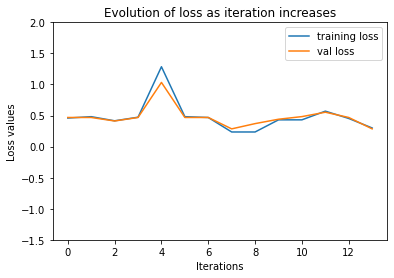

              precision    recall  f1-score   support

        Male       0.96      0.82      0.88       830
      Female       0.60      0.89      0.71       250

    accuracy                           0.84      1080
   macro avg       0.78      0.85      0.80      1080
weighted avg       0.88      0.84      0.84      1080


Confusion matrix is as follows:
[[680 150]
 [ 28 222]]


(1, 50)
Plotting training and validation loss:


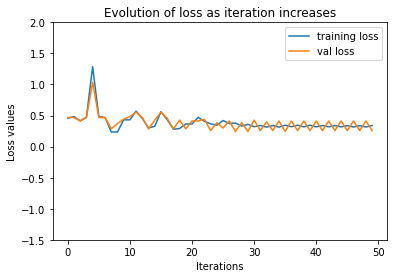

              precision    recall  f1-score   support

        Male       0.97      0.79      0.87       830
      Female       0.57      0.91      0.70       250

    accuracy                           0.82      1080
   macro avg       0.77      0.85      0.78      1080
weighted avg       0.87      0.82      0.83      1080


Confusion matrix is as follows:
[[657 173]
 [ 23 227]]


(1, 100)
Plotting training and validation loss:


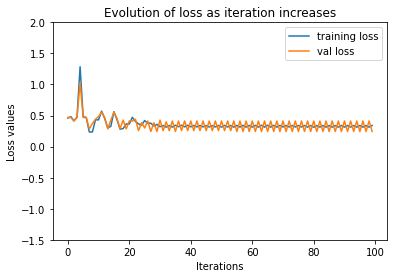

              precision    recall  f1-score   support

        Male       0.97      0.79      0.87       830
      Female       0.57      0.91      0.70       250

    accuracy                           0.82      1080
   macro avg       0.77      0.85      0.78      1080
weighted avg       0.87      0.82      0.83      1080


Confusion matrix is as follows:
[[657 173]
 [ 23 227]]


(0.1, 14)
Plotting training and validation loss:


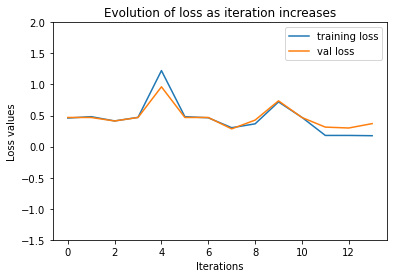

              precision    recall  f1-score   support

        Male       0.91      0.95      0.93       830
      Female       0.80      0.69      0.74       250

    accuracy                           0.89      1080
   macro avg       0.85      0.82      0.83      1080
weighted avg       0.88      0.89      0.88      1080


Confusion matrix is as follows:
[[786  44]
 [ 78 172]]


(0.1, 50)
Plotting training and validation loss:


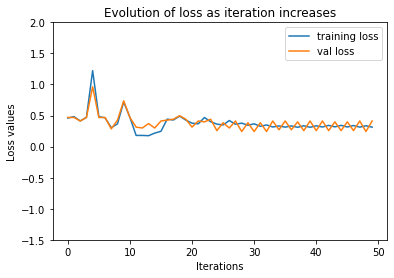

              precision    recall  f1-score   support

        Male       0.83      0.98      0.90       830
      Female       0.85      0.32      0.47       250

    accuracy                           0.83      1080
   macro avg       0.84      0.65      0.68      1080
weighted avg       0.83      0.83      0.80      1080


Confusion matrix is as follows:
[[816  14]
 [170  80]]


(0.1, 100)
Plotting training and validation loss:


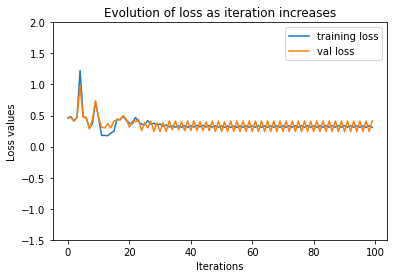

              precision    recall  f1-score   support

        Male       0.83      0.98      0.90       830
      Female       0.85      0.33      0.47       250

    accuracy                           0.83      1080
   macro avg       0.84      0.66      0.69      1080
weighted avg       0.84      0.83      0.80      1080


Confusion matrix is as follows:
[[816  14]
 [168  82]]


(0.01, 14)
Plotting training and validation loss:


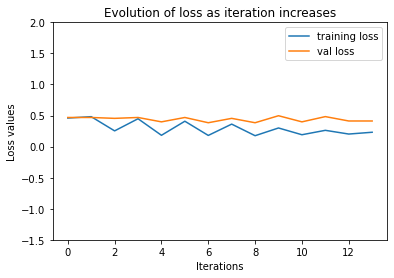

              precision    recall  f1-score   support

        Male       0.87      0.97      0.92       830
      Female       0.85      0.50      0.63       250

    accuracy                           0.86      1080
   macro avg       0.86      0.74      0.77      1080
weighted avg       0.86      0.86      0.85      1080


Confusion matrix is as follows:
[[807  23]
 [124 126]]


(0.01, 50)
Plotting training and validation loss:


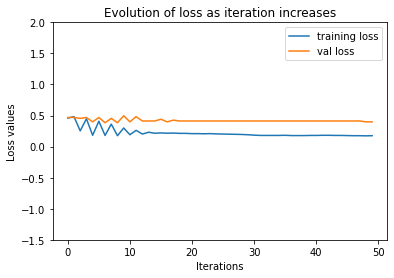

              precision    recall  f1-score   support

        Male       0.90      0.96      0.93       830
      Female       0.82      0.66      0.73       250

    accuracy                           0.89      1080
   macro avg       0.86      0.81      0.83      1080
weighted avg       0.88      0.89      0.88      1080


Confusion matrix is as follows:
[[793  37]
 [ 85 165]]


(0.01, 100)
Plotting training and validation loss:


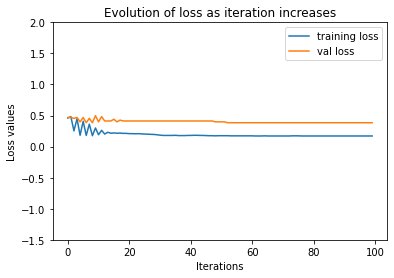

              precision    recall  f1-score   support

        Male       0.91      0.95      0.93       830
      Female       0.81      0.68      0.74       250

    accuracy                           0.89      1080
   macro avg       0.86      0.81      0.83      1080
weighted avg       0.89      0.89      0.89      1080


Confusion matrix is as follows:
[[791  39]
 [ 81 169]]


(0.0001, 14)
Plotting training and validation loss:


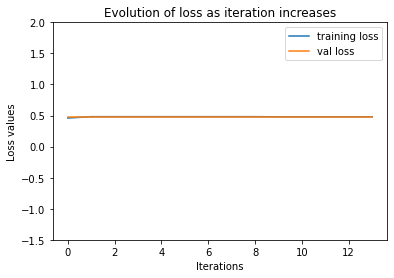

              precision    recall  f1-score   support

        Male       0.77      0.99      0.86       830
      Female       0.00      0.00      0.00       250

    accuracy                           0.76      1080
   macro avg       0.38      0.49      0.43      1080
weighted avg       0.59      0.76      0.66      1080


Confusion matrix is as follows:
[[821   9]
 [250   0]]


(0.0001, 50)
Plotting training and validation loss:


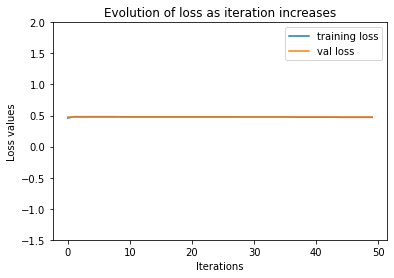

              precision    recall  f1-score   support

        Male       0.77      0.99      0.87       830
      Female       0.00      0.00      0.00       250

    accuracy                           0.76      1080
   macro avg       0.38      0.50      0.43      1080
weighted avg       0.59      0.76      0.67      1080


Confusion matrix is as follows:
[[825   5]
 [250   0]]


(0.0001, 100)
Plotting training and validation loss:


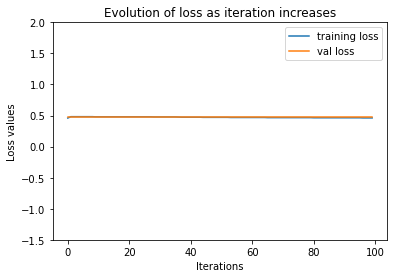

              precision    recall  f1-score   support

        Male       0.77      1.00      0.87       830
      Female       0.00      0.00      0.00       250

    accuracy                           0.77      1080
   macro avg       0.38      0.50      0.43      1080
weighted avg       0.59      0.77      0.67      1080


Confusion matrix is as follows:
[[829   1]
 [250   0]]




In [9]:
#Creating logistic regression model and training it on the training data for gender recognition probelm
LL = LogisticRegression(XTrainp1,YTrainp1,epochs=0,lr=0,problem=0)
LL.validateModel(hyperparameters,XTrainp1,YTrainOnep1,XValp1,YValOnep1)

# Analysis


`Depending on our hyperparameters list we only found 2 possible candidates that are lr,epochs=(1,14) and (0.1,14) but after watching the behaviour further we noticed that (1,14) oscillates more rapidly than (0.1,14) so we chose (0.1,14) as our final tuned hyperparameter and with that an average macro F1 score of 81% was achieved on the testing data`

Plotting training and validation loss:


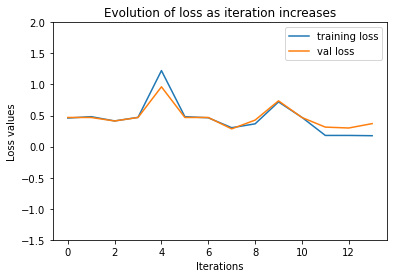

              precision    recall  f1-score   support

        Male       0.91      0.95      0.93       830
      Female       0.80      0.69      0.74       250

    accuracy                           0.89      1080
   macro avg       0.85      0.82      0.83      1080
weighted avg       0.88      0.89      0.88      1080


Confusion matrix is as follows:
[[786  44]
 [ 78 172]]


In [10]:
LL = LogisticRegression(XTrainp1,YTrainp1,epochs=14,lr=0.1,problem=0)
LL.gradient_descent(XTrainp1,YTrainOnep1,XValp1,YValOnep1)

In [11]:
#Testing the logistic regression model on the testing data
print("For gender classification the asked stats are as follows:")
ypred = LL.predict(XTestp1)
LL.confusionMatrix(ypred,YTestp1)

For gender classification the asked stats are as follows:
              precision    recall  f1-score   support

        Male       0.91      0.91      0.91       130
      Female       0.71      0.72      0.72        40

    accuracy                           0.86       170
   macro avg       0.81      0.82      0.81       170
weighted avg       0.87      0.86      0.87       170


Confusion matrix is as follows:
[[118  12]
 [ 11  29]]


In [12]:
hyperparameters = [(1,50),(1,500),(1,1000),(0.1,50),(0.1,500),(0.1,1000),(0.01,50),(0.01,500),(0.01,1000),(0.001,50),(0.001,500),(0.001,1000)]

(1, 50)
Plotting training and validation loss:


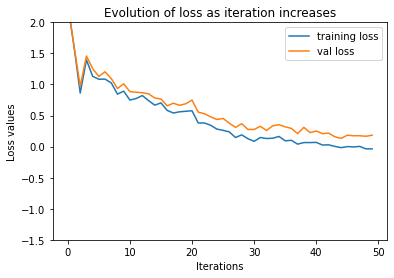

C:\Users\Dyass\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       0.33      1.00      0.50         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

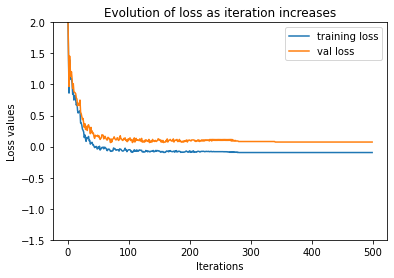

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

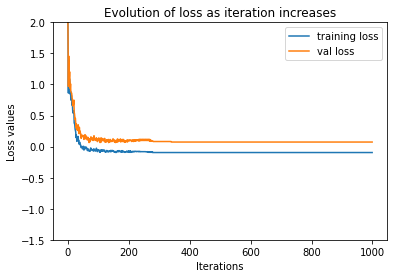

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

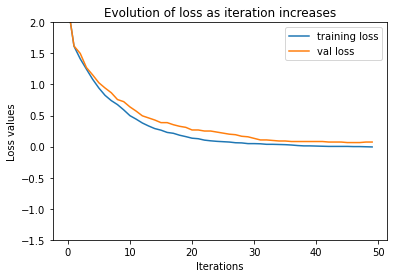

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      0.33      0.50         6
           8       1.00      1.00      1.00         6
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         6
          11       1.00      0.83      0.91         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       0.86      1.00      0.92         6
          17       0.86    

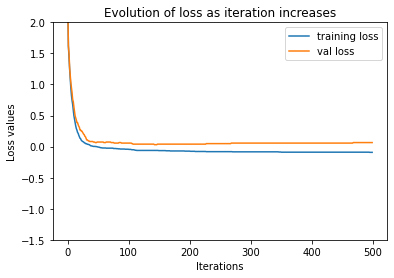

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

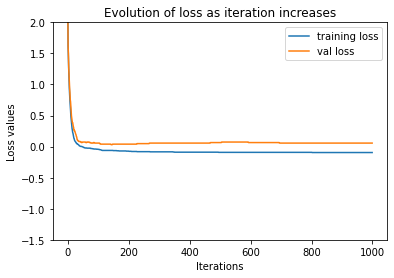

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

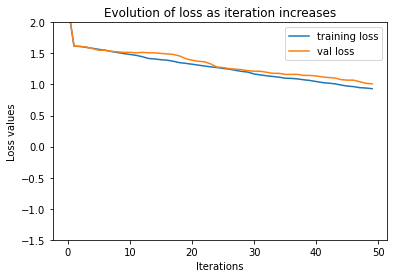

              precision    recall  f1-score   support

           0       0.35      1.00      0.52         6
           1       0.30      1.00      0.46         6
           2       0.67      1.00      0.80         6
           3       0.60      1.00      0.75         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.86      1.00      0.92         6
           9       1.00      0.83      0.91         6
          10       0.67      0.33      0.44         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         6
          13       0.62      0.83      0.71         6
          14       1.00      1.00      1.00         6
          15       0.00      0.00      0.00         6
          16       1.00      0.50      0.67         6
          17       0.00    

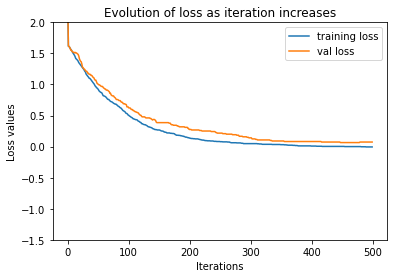

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      0.33      0.50         6
           8       1.00      1.00      1.00         6
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         6
          11       1.00      0.83      0.91         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       0.86      1.00      0.92         6
          17       0.86    

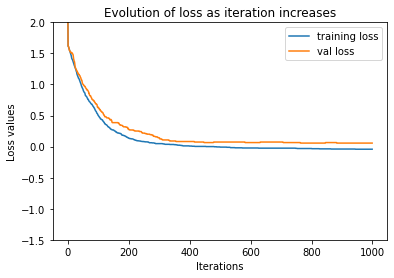

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      0.67      0.80         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

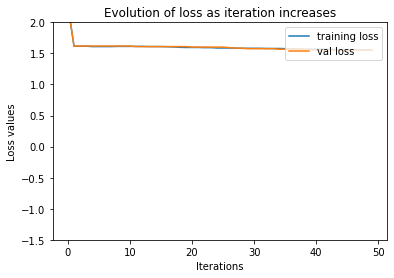

              precision    recall  f1-score   support

           0       0.43      1.00      0.60         6
           1       0.06      1.00      0.11         6
           2       0.83      0.83      0.83         6
           3       0.75      0.50      0.60         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
           9       1.00      0.50      0.67         6
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         6
          13       0.80      0.67      0.73         6
          14       1.00      0.17      0.29         6
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         6
          17       0.00    

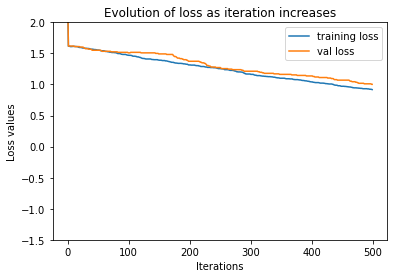

              precision    recall  f1-score   support

           0       0.35      1.00      0.52         6
           1       0.32      1.00      0.48         6
           2       0.67      1.00      0.80         6
           3       0.60      1.00      0.75         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.86      1.00      0.92         6
           9       1.00      0.83      0.91         6
          10       0.67      0.33      0.44         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         6
          13       0.62      0.83      0.71         6
          14       1.00      1.00      1.00         6
          15       0.00      0.00      0.00         6
          16       1.00      0.50      0.67         6
          17       0.00    

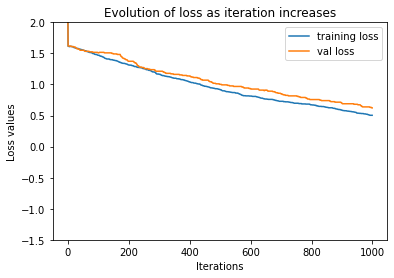

              precision    recall  f1-score   support

           0       0.43      1.00      0.60         6
           1       0.75      1.00      0.86         6
           2       0.67      1.00      0.80         6
           3       0.55      1.00      0.71         6
           4       0.00      0.00      0.00         6
           5       1.00      0.17      0.29         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       1.00      1.00      1.00         6
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         6
          11       1.00      0.17      0.29         6
          12       0.00      0.00      0.00         6
          13       0.67      1.00      0.80         6
          14       0.86      1.00      0.92         6
          15       0.00      0.00      0.00         6
          16       1.00      0.83      0.91         6
          17       0.00    

In [13]:
#Creating logistic regression model and training it on the training data for gender recognition probelm
LL = LogisticRegression(XTrainp2,YTrainp2,epochs=0,lr=0,problem=1)
LL.validateModel(hyperparameters,XTrainp2,YTrainOnep2,XValp2,YValOnep2)

# Analysis

`As seen in the above graphs models with lr=1 irrespective of epochs have an oscillatory behaviour whereas in case of lr=0.001 the loss fell too quickly and validation loss is lesser than training loss, so we did not chose them. As seen in the graphs of lr=0.01 and epochs=1000 the validation and training loss are getting reduced smoothly so we ended up chosing lr=0.01 and epochs=1000 `

Plotting training and validation loss:


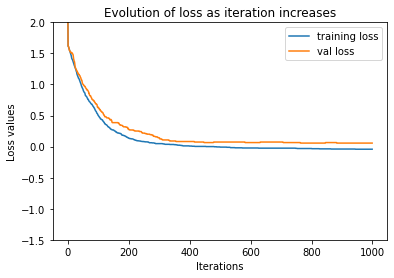

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      0.67      0.80         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00    

In [14]:
#Creating logistic regression model and training it on the training data for speaker recognition probelm
LL = LogisticRegression(XTrainp2,YTrainp2,problem=1,lr=0.01,epochs=1000)
LL.gradient_descent(XTrainp2,YTrainOnep2,XValp2,YValOnep2)

In [15]:
#Testing the logistic regression model on the testing data for speaker recognition problem
print("For speaker classification the asked stats are as follows:")
ypred = LL.predict(XTestp2)
LL.confusionMatrix(ypred,YTestp2)

For speaker classification the asked stats are as follows:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.0